We will use the finite differenc methodology of https://assets.researchsquare.com/files/rs-2243537/v1_covered.pdf?c=1671034302 to solve the inverse problem of the car.

THis time though we will be learning K using a Neural network and K will vary systematically with temperature, which will vary throughout the day

# Libraries

In [1]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation
from scipy.stats import norm

In [2]:
def plot_car_trajectory(simulator,sampling_freq):
    fig,ax = plt.subplots(2,3, figsize=(12, 9))
    
    states_sim = simulator.data['_x'][::sampling_freq]
    time =  simulator.data['_time'][::sampling_freq]
    friction = simulator.data['_tvp'][::sampling_freq,0]
    wind = simulator.data['_tvp'][::sampling_freq,1]
    force = simulator.data['_u'][::sampling_freq]
    
    ax[0,0].plot(time,states_sim[:,1]*3.6)
    ax[0,0].set_xlabel("Time")
    ax[0,0].set_ylabel("Velocity (km/hr)")    
    
    dist = states_sim[:,0]/1000
    ax[0,1].plot(time,dist)
    ax[0,1].set_xlabel("Time")
    ax[0,1].set_ylabel("Distance (km)")     
    ax[1,0].plot(time,friction*(1-exp(-states_sim[:,1])),label = "Rolling")
    

    ax[1,0].plot(time,k1*states_sim[:,1]**2,label = "Aero")
    ax[1,0].plot(time,wind,label = "Wind")
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Drag Components")    
    ax[1,0].legend(loc="upper right")
    
    ax[1,1].plot(time,force)
    ax[1,1].set_xlabel("Time")
    ax[1,1].set_ylabel("Acceleration input")     
    
    total_fuel_burn = np.cumsum(a_0 + a_1*force)/1000
    ax[0,2].plot(time,total_fuel_burn)
    ax[0,2].set_xlabel("Time")
    ax[0,2].set_ylabel("Total Fuel Burn (klitres)")     
    instaneous_milage = (total_fuel_burn[1:] - total_fuel_burn[0:-1]) / (dist[1:] - dist[0:-1])

    ax[1,2].plot(time[1:],instaneous_milage)
    ax[1,2].set_xlabel("Time (secs)")
    ax[1,2].set_ylabel("Instaneous Milage (klitres/km)")     

In [3]:
# Defining the constants

a_0 = 0 # assume that fuel burn and force are 1-1 correlated
a_1 = 1
m = 500 # kg # car is half a ton
k1 = 50/450

model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))

k0 = model.set_variable(var_type='_tvp', var_name='friction', shape=(1, 1))
fw = model.set_variable(var_type='_tvp', var_name='wind', shape=(1, 1))
acc = model.set_variable(var_type='_u', var_name='acc', shape=(1,1))

x_next = vertcat(x[1], acc/m - (k0*(1-exp(-x[1])) + k1*x[1]**2)/m - fw/m)
model.set_rhs('x',x_next)
model.setup()

params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)


# Setting up the friction. Friction is a quadraticve function of temperature 
Tc = 2000
temperature_data = np.zeros((Tc,))
temperature_data[0] = 20 # 20 degrees
for i in range(Tc-1):
    temperature_data[i+1] = temperature_data[i]+1*np.random.normal(0,1)

def friction(temp):
    return 0.1*temp**2 + 10 + 0.01*temp

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    tvp_template['wind'] = 0*np.random.normal(0,10)
    tvp_template['friction'] = max(0,friction(temperature_data[int(np.floor(t_now))]) +10*np.random.normal(0,1))
    return tvp_template

simulator.set_tvp_fun(tvp_fun)
simulator.setup()

simulator.x0 = np.array([0,0])

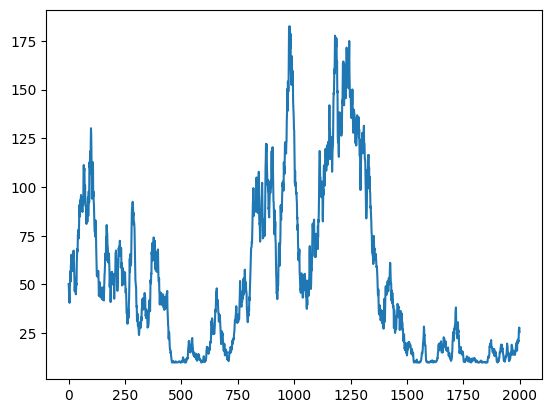

In [4]:
plt.plot(friction(temperature_data))


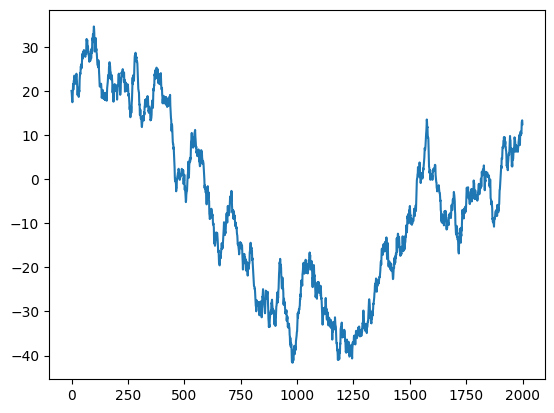

In [5]:
plt.plot(temperature_data)

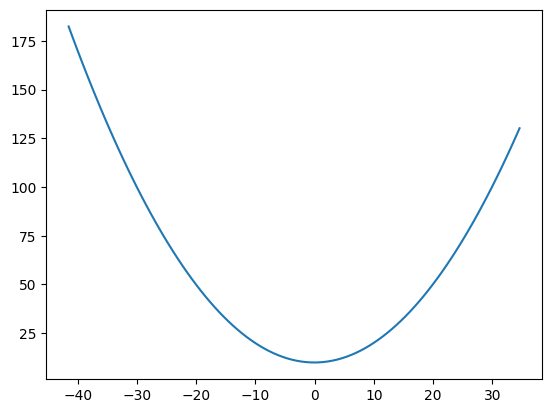

In [6]:
temperature = np.linspace(min(temperature_data),max(temperature_data),100)
plt.plot(temperature,friction(temperature))

In [7]:
min(temperature_data)

-41.56485730738083

In [8]:
v_s = np.sqrt(450)
best_u = 50*(1-np.exp(-v_s)) + 50/450*v_s**2

In [9]:
def expert_controller(simulator,target_vel):
    current_distance = simulator.data['_x'][-1,0]
    current_velocity = simulator.data['_x'][-1,1]
    current_force = simulator.data['_u'][-1]
    if current_velocity < target_vel and current_force == 0:
        u0 = (150 + 1)*np.ones((1,1))
    elif current_velocity < target_vel and current_force > 0:
        u0 = (current_force + 1)*np.ones((1,1))
    else:
        u0 = 0*np.ones((1,1))
    return u0

In [10]:
u0 = best_u*np.ones((1,1))
simulator.reset_history()
simulator.x0 = np.array([0,0])
for i in range(Tc):
    simulator.make_step(u0)
    u0 = expert_controller(simulator,v_s)

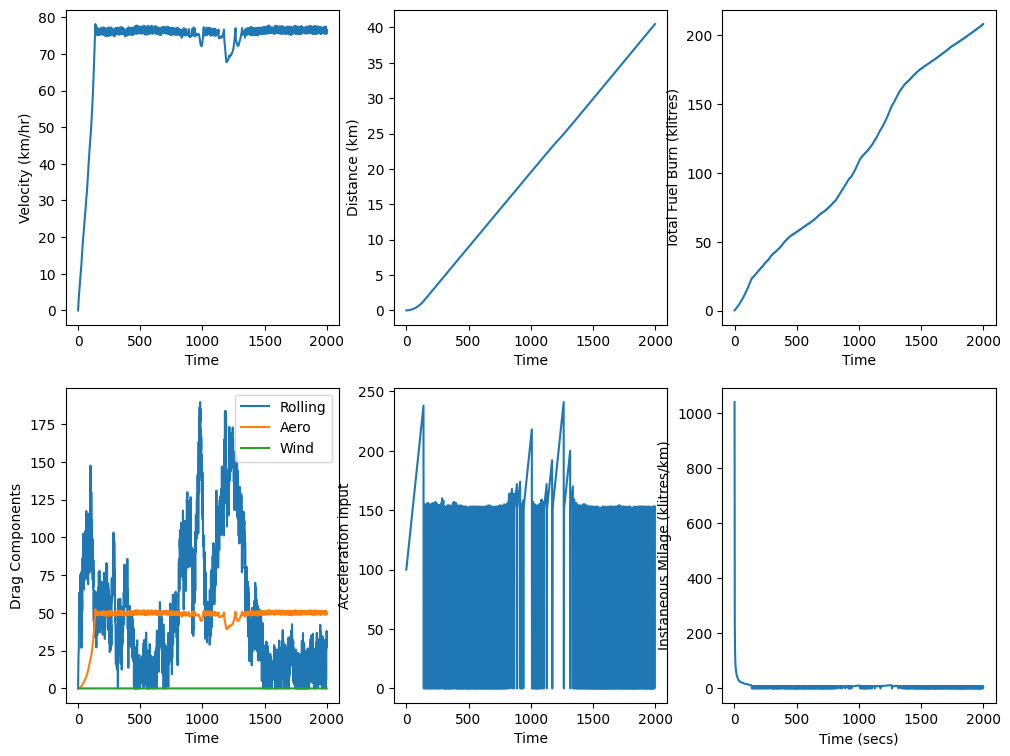

In [11]:
plot_car_trajectory(simulator,sampling_freq = 1)

In [28]:
# Save the data

#print the data
import pandas as pd
data = np.hstack((simulator.data['_time'],temperature_data,simulator.data['_x'],simulator.data['_u'],simulator.data['_tvp']))
df = pd.DataFrame(data, columns = ['time','temperature','displacement','velocity','force','friction_0','wind'])
df.to_csv('car_example.csv')


# Now let's try to measure the friction using finite differencing scheme

Let us discretise time as $t_i$ for $i$ between $0$ and $N$. 

Let 
$$
K_i = K(t_i)
$$

be our unknown parameters that we wish to solve for

Then the discrete loss function will be:

$$
L_i = \frac{M_c V_c}{T_c}(\frac{v_{i+1} - v_{i-1}}{2\Delta t}) - (U_c u_i - (K_i(1-e^{-V_cv_i}) + \frac{50}{450}V_c^2v_i^2) \quad \forall \quad i = 1...N-1
$$

on the boundary we need to use the forward and backward derivative (https://en.wikipedia.org/wiki/Finite_difference):

$$
L_0 = \frac{M_c V_c}{T_c}(\frac{v_{1} - v_{0}}{\Delta t}) - (U_c u_0 - (K_0(1-e^{-V_cv_0}) + \frac{50}{450}V_c^2v_0^2) 
$$
 and 
 
$$
L_N =  \frac{M_c V_c}{T_c}(\frac{v_{N} - v_{N-1}}{\Delta t}) - (U_c u_N - (K_N(1-e^{-V_cv_N}) + \frac{50}{450}V_c^2v_N^2)
$$

Which can be written in compact vector form as:

$$
\textbf{L} = \frac{M_c V_c}{T_c\Delta t}\textbf{A}\textbf{v} -(U_c \textbf{u} - (\textbf{K}(1-e^{-V_c \textbf{v}}) + \frac{50}{450}V_c^2\textbf{v}^2)
$$

where $A$ is

$$
 \begin{bmatrix}
-1 & 1 & 0 & 0 \\
-\frac{1}{2} & 0 & \frac{1}{2} & 0 \\
0 & .. & ... & 0 \\
0 & -\frac{1}{2} & 0 &\frac{1}{2} \\
0 & 0 & -1 & 1 
\end{bmatrix} 
$$
(or could take a different form if we use a different type of finite differencing)
 

and our goal is to minimise $L^T L$


Modification

We can modify our fomulation by restricting K to only vary once every J points. We can implement this in the folloinwg way:

Suppose $\textbf{K}$ is a vector of length $floor(K/J)$ with index h. left F map the hth point onto the ith point. Then the effective K is:  


$$
K_{eff} = \textbf{F}\textbf{K} 
$$

In [12]:
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import Adam
import itertools

In [13]:
def create_A(N,method = "central"):
    if method == "central":
        # Setting up the A matrix (central differcing)
        A = numpy.zeros((N,N))
        np.fill_diagonal(A[1:], -0.5)
        np.fill_diagonal(A[:,1:], 0.5)
        A[0,0] = -1
        A[0,1] = 1
        A[N-1,N-1] = 1
        A[N-1,N-2] = -1
        A = torch.from_numpy(A).float()
    elif method == "forward":
        # Setting up the A matrix (forward differencing)
        A = numpy.zeros((N,N))
        np.fill_diagonal(A, 1)
        np.fill_diagonal(A[1:], -1)
        A[0,0] = -1
        A[0,1] = 1
        A[N-1,N-1] = 1
        A[N-1,N-2] = -1
        A = torch.from_numpy(A).float()
    return A

In [14]:
N = len(simulator.data['_time'])

# Normalising constants
Mc = 500.0
Tc = len(simulator.data['_time'])
Vc = 80.0/3.6
Uc = 250.0
delt = ((simulator.data['_time'][1] - simulator.data['_time'][0]) / Tc)[0]



# Parameter resp;itopm
J = 50

# Register the K parameters
K = nn.Parameter(0.1*torch.ones(int(np.floor(N/J)),1))

# Setting up the F matrix to map K to i
F = numpy.zeros((N,len(K)))
for i in range(len(K)):
    F[(J*i):(J*i+J),i] = 1
F = torch.from_numpy(F).float()

# Get the data from the simulation
t_interior = torch.from_numpy(simulator.data['_time']).float()
t_interior = t_interior.clone()/Tc
sensor_data = torch.from_numpy(np.hstack((simulator.data['_x'],simulator.data['_u']))).float().div(torch.tensor([[1,Vc,Uc]]))
temperature_data = torch.from_numpy(temperature_data)[:,None].float()

# Create A
A = create_A(N)



In [15]:
temperature_data

tensor([[20.0000],
        [19.5828],
        [18.5109],
        ...,
        [13.2133],
        [13.3371],
        [12.4543]])

In [16]:
# Setting up the friction approximator
class Friction_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out

In [17]:

# Setting up the calculation
def compute_loss(fric_approx,temp_data): 
    vel = sensor_data[:,1][:,None].float()
    u = sensor_data[:,2][:,None].float()
    K_approx = fric_approx(temp_data)
    L = torch.mm(Mc*Vc/Tc/delt*A,vel) - (Uc*u - (K_approx*(1-torch.exp(-Vc*vel)) + 50/450*Vc*vel*Vc*vel ))
    loss = torch.sqrt(torch.mm(L.transpose(0,1),L).squeeze())
    return loss
    
def optimise(optimiser,fric_approx,temp_data):
    optimiser.zero_grad()
    loss = compute_loss(fric_approx,temp_data)
    loss.backward()
    optimiser.step()
    return loss

In [18]:
lr = 0.01
epochs = 30000
Kapprox = Friction_approximator(2,6)
learnable_params = list(Kapprox.parameters())
k_optimizer = Adam(learnable_params, lr=lr)

In [19]:
loss_vector = []
iteration_vector =[]
for i in range(epochs):
    loss = optimise(k_optimizer,Kapprox,temperature_data)
    if i % 1000==0:
        iteration_vector.append(i)
        loss_vector.append(loss.detach().numpy())
        print(i,loss.detach().numpy())

0 3464.3884
1000 2546.862
2000 1861.4221
3000 1737.8951
4000 1714.6854
5000 1704.6586
6000 1700.9697
7000 1700.9083
8000 1699.8159
9000 1699.8346
10000 1699.5056
11000 1699.3835
12000 1699.2498
13000 1698.9956
14000 1699.3464
15000 1698.4822
16000 1698.3137
17000 1699.6298
18000 1700.792
19000 1698.0916
20000 1698.0369
21000 1697.842
22000 1697.619
23000 1697.5542
24000 1697.5087
25000 1697.4316
26000 1697.2688
27000 1697.1997
28000 1697.1655
29000 1697.0739


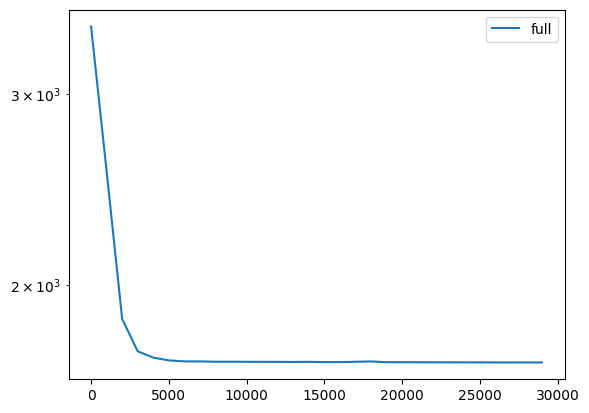

In [20]:
plt.figure()
plt.plot(iteration_vector,loss_vector,label = 'full')
plt.yscale('log')
plt.legend()

<Figure size 640x480 with 0 Axes>

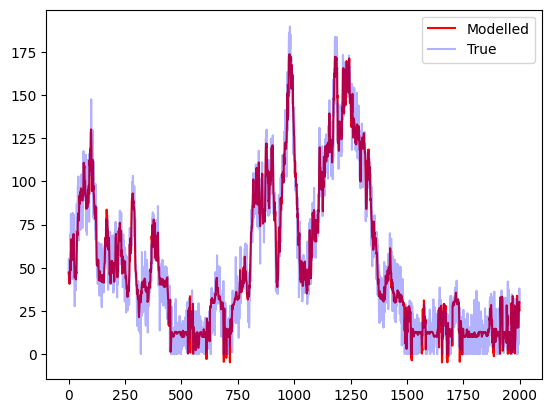

In [21]:
plt.figure()
# NOw interrogate the R approximator
with torch.no_grad():
    r_prediction = Kapprox(temperature_data).numpy()
    
true_k = simulator.data['_tvp'][:,0]
plt.figure()
plt.plot(simulator.data['_time'],r_prediction,'r-',label = "Modelled")
plt.plot(simulator.data['_time'],true_k,'b-',label = "True",alpha = 0.3)
plt.legend()

<Figure size 640x480 with 0 Axes>

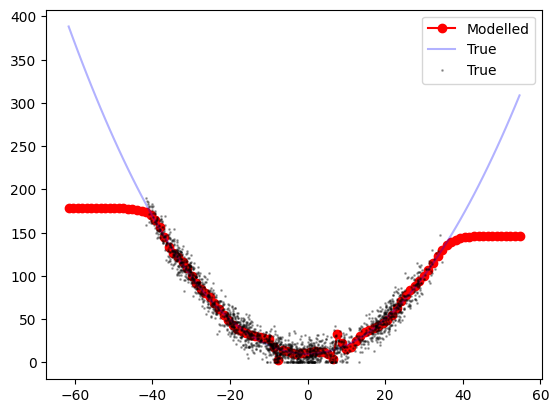

In [23]:
plt.figure()
# NOw interrogate the R approximator
t_data = torch.linspace(min(temperature_data)[0]-20, max(temperature_data)[0]+20, steps=100).view(-1, 1)
with torch.no_grad():
    r_prediction = Kapprox(t_data).numpy()
    
true_k = simulator.data['_tvp'][:,0]
plt.figure()
plt.plot(t_data,r_prediction,'o-r',label = "Modelled")
plt.plot(t_data,friction(t_data),'b-',label = "True",alpha = 0.3)
plt.plot(temperature_data,true_k,'ko',label = "True",alpha = 0.3,markersize = 1)

plt.legend()